## Deep Q-Learning

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My\ Drive/Deep_Q

/content/drive/My Drive/Deep_Q


In [4]:
!pip install gym

In [5]:
# Dependencies
import gym
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from mish import Mish
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Seed
seed = 5
env.seed(seed)
random.seed(seed)
np.random.seed(seed)

In [0]:
# Training parameterss
discount_factor = 0.99
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
train_start = 1000
memory_size = 10000
n_episodes = 2000
n_win_ticks = 195
n_avg_scores = 100
render = False

In [8]:
# Build model
def build_model():
    model = Sequential()
    model.add(Dense(96, input_dim=state_size, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(48, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(24, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(action_size, kernel_initializer='he_uniform'))
    model.compile(Adam(lr=0.001), loss='mse')
    return model

model = build_model()
target_model = build_model()

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                480       
_________________________________________________________________
mish_2 (Mish)                (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                4656      
_________________________________________________________________
mish_3 (Mish)                (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1176      
_________________________________________________________________
mish_4 (Mish)                (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)             

In [0]:
# Training helpers
# Source: https://github.com/yanpanlau/CartPole/blob/master/DQN/CartPole_DQN.py
def update_target_model():
    target_model.set_weights(model.get_weights())

def get_action(state, epsilon):
    return np.random.randint(action_size) if np.random.rand() <= epsilon else np.argmax(model.predict(state)[0])

def train_replay():
    if len(memory) < train_start:
        return
    minibatch = random.sample(memory,  min(batch_size, len(memory)))
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = model.predict(state_t)
    Q_sa = target_model.predict(state_t1)
    targets[range(batch_size), action_t] = reward_t + discount_factor * np.max(Q_sa, axis=1) * np.invert(terminal)
    model.train_on_batch(state_t, targets)







[Episode 0] Average Score: 27.0


[Episode 100] Average Score: 140.21
Solved after 8 tries! \o/
[Episode 200] Average Score: 382.01
[Episode 300] Average Score: 435.57
[Episode 400] Average Score: 388.33
[Episode 500] Average Score: 335.1
[Episode 600] Average Score: 293.13
[Episode 700] Average Score: 347.31
[Episode 800] Average Score: 376.51
[Episode 900] Average Score: 284.27
[Episode 1000] Average Score: 418.94
[Episode 1100] Average Score: 415.88
[Episode 1200] Average Score: 497.74
[Episode 1300] Average Score: 418.46
[Episode 1400] Average Score: 421.49
[Episode 1500] Average Score: 448.08
[Episode 1600] Average Score: 466.44
[Episode 1700] Average Score: 333.93
[Episode 1800] Average Score: 299.65
[Episode 1900] Average Score: 335.31


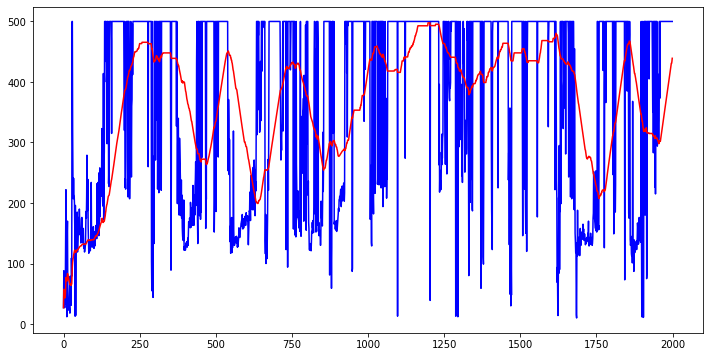

In [10]:
# Training
avg_scores = []
all_scores = []
scores = deque(maxlen=n_avg_scores)
memory = deque(maxlen=memory_size)

def learn_to_balance():
    epsilon = 1.0 # Start with randomness
    has_won = False

    for e in range(n_episodes):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            memory.append((state, action, reward if not done else -100, next_state, done))
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay # Decrease randomness
            train_replay()
            score += reward
            state = next_state
            
            if render:
                env.render()

            if done:
                env.reset()
                update_target_model()
                scores.append(score)
                all_scores.append(score)
                avg_score = np.mean(scores)
                avg_scores.append(avg_score)

                if not has_won and e >= n_avg_scores and avg_score >= n_win_ticks:
                    # Find first score greater than 195 where the average is >= 195 over the following 100 episodes.
                    solution_episode_idx = max(next(x[0] for x in enumerate(all_scores) if x[1] >= n_win_ticks), e - n_win_ticks) 
                    print('Solved after {} tries! \o/'.format(solution_episode_idx))
                    has_won = True

                if e % n_avg_scores == 0:
                    print('[Episode {}] Average Score: {}'.format(e, avg_score))

# Train model
# The challenge is solved at episode 8. The mean score remains >= 195 for the following 100 episodes.
# A higher score is very likely achievable through hyperparameter optimization and seed exploration.
# A better performance metric would span more episodes and cover a range of initial environment seeds.
learn_to_balance()

# Plot results
plt.figure(figsize=(12,6))
plt.plot(all_scores, color='blue')
plt.plot(avg_scores, color='red')
plt.show()              